# If Running in Google CoLab Connect to Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("gdrive/MyDrive/Lentil Project/")

In [ ]:
pwd

'/content/gdrive/MyDrive/Lentil Project'

# If not Running in CoLab, Start Here

In [ ]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim

import pandas as pd

from torchvision.datasets import CIFAR10

from skimage import io

%matplotlib inline

Data Loader

In [ ]:
class LentilDataset(Dataset): 
    def __init__(self, paths, transformer): 
        super(LentilDataset, self).__init__()
        self.image_paths = paths
        self.transformer = transformer
        
    def __len__(self): 
        return len(self.image_paths)
    
    def __getitem__(self, item): 
        path = self.image_paths[item]
        image = io.imread(path)
        
        image = self.transformer(image)
            
        return item, image

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(256, 256)),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [ ]:
df = pd.read_csv('metadata/real_features.csv')
paths = df.Image.tolist()
# this may need to be changed depending on where your images are saved
for i in range(len(paths)):
    paths[i] = paths[i].split("/")[-2]+"/"+paths[i].split("/")[-1]

In [ ]:
train_paths, valid_paths = np.split(paths, [int(.8*len(df))])

In [ ]:
train_dataset = LentilDataset(train_paths, transform)
valid_dataset = LentilDataset(valid_paths, transform)
train_dataset.image_paths.shape

(1272,)

In [ ]:
# Define dataloaders. 
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0
)
valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0
)

In [ ]:
for data in train_loader:
    items, image = data
    print(image.shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size

**Model Definition**

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, stride=2, padding=1, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(), # Shape : 128 by 128

            nn.Conv2d(in_channels=8, out_channels=16, stride=2, padding=1, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(), # Shape : 64 by 64

            nn.Conv2d(in_channels=16, out_channels=32, stride=2, padding=1, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(), # Shape : 32 by 32

            nn.Conv2d(in_channels=32, out_channels=64, stride=2, padding=1, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(), # Shape : 16 by 16

            nn.Conv2d(in_channels=64, out_channels=64, stride=2, padding=1, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(), # Shape : 8 by 8

            nn.Flatten(start_dim=1), 
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
        )
        self.linear_decoder = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4096),
            nn.ReLU()
            
        )
        self.decoder =nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(), # Shape : 16 by 16

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(), # Shape : 32 by 32

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(), # Shape : 64 by 64

            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(8),
            nn.ReLU(), # Shape : 128 by 128

            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1), # Shape : 256 by 256
            
            nn.Sigmoid() # To change the output range of the output images into a normal range between 0 and 1.  
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        linearly_decoded = self.linear_decoder(encoded)
        linearly_decoded = linearly_decoded.view(-1, 64, 8, 8) # Reshape from linear to conv2d format.
        decoded = self.decoder(linearly_decoded)
        return decoded
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Set device to ', device)
model = CNN_Model()
model = model.to(device)

Set device to  cuda


In [ ]:
print(model)

CNN_Model(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_

In [ ]:
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
MAXEPOCH = 25

train_loss_tracking = []
vlaid_loss_tracking = []

print("Start")
for epoch in range(MAXEPOCH):
    print("Epoch:", epoch)
    # Change the development mode to the training mode. 
    model.train()
    running_loss = 0.0
    
    running_steps = 0
    for i, data in enumerate(train_loader, 0):
        _, images = data
        images=images.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, images.clone())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        running_steps += 1
    train_loss = running_loss / running_steps
    train_loss_tracking.append(train_loss)

    print(f'Train --> Epoch: {epoch}, Loss: {train_loss}.')

    # Evaluate the model for this epoch. 
    # Change the development mode to the evaluating mode. 
    model.eval()
    with torch.no_grad():
        running_loss = 0.0

        running_steps = 0
        for i, data in enumerate(valid_loader, 0):
            _, features = data
            features=features.to(device)

            outputs = model(features)
            loss = criterion(outputs, features)

            running_loss += loss.cpu().item()
  
            running_steps += 1
        valid_loss = running_loss / running_steps
        vlaid_loss_tracking.append(valid_loss)

        print(f'Valid --> Epoch: {epoch}, Loss: {valid_loss}.')
        print('-' * 50)
        
print('Finished.')

Start
Epoch: 0
Train --> Epoch: 0, Loss: 2.1255135610699654.
Valid --> Epoch: 0, Loss: 1.6213488042354585.
--------------------------------------------------
Epoch: 1
Train --> Epoch: 1, Loss: 1.7115750074386598.
Valid --> Epoch: 1, Loss: 1.442501026391983.
--------------------------------------------------
Epoch: 2
Train --> Epoch: 2, Loss: 1.5442224696278573.
Valid --> Epoch: 2, Loss: 1.3220978736877442.
--------------------------------------------------
Epoch: 3
Train --> Epoch: 3, Loss: 1.4696049481630324.
Valid --> Epoch: 3, Loss: 1.284546172618866.
--------------------------------------------------
Epoch: 4
Train --> Epoch: 4, Loss: 1.432378923892975.
Valid --> Epoch: 4, Loss: 1.2435095816850663.
--------------------------------------------------
Epoch: 5
Train --> Epoch: 5, Loss: 1.4107222616672517.
Valid --> Epoch: 5, Loss: 1.238005194067955.
--------------------------------------------------
Epoch: 6
Train --> Epoch: 6, Loss: 1.3987610965967179.
Valid --> Epoch: 6, Loss: 1.228

**Visualize the Loss Over Different Epochs**

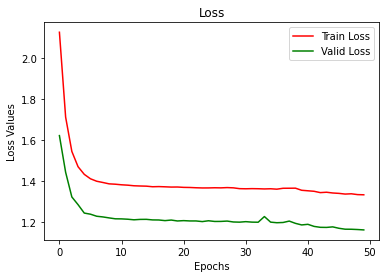

In [ ]:
plt.plot(range(len(train_loss_tracking)), train_loss_tracking, 'r-', label='Train Loss')
plt.plot(range(len(vlaid_loss_tracking)), vlaid_loss_tracking, 'g-', label='Valid Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Values')
plt.legend()
plt.show()

In [ ]:
# change to where you want model saved
PATH = 'CNNModel1/CNN1.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# Load the best saved model. 
checkpoint = torch.load('CNNModel1/CNN1.pth', map_location=torch.device(str(device)))
# Define the base model.
model = CNN_Model()
# Load the weights. 
model.load_state_dict(checkpoint)
model = model.to(device)
model = model.eval()

In [ ]:
# encode the images

df = pd.read_csv('metadata/real_features.csv')
paths = df.Image.tolist()
for i in range(len(paths)):
  paths[i] = paths[i].split("/")[-1]

image_dataset = LentilDataset(paths, transform)


image_loader = DataLoader(
    image_dataset, 
    batch_size=64, 
    shuffle=False,
    num_workers=0
)

output_images = []
output_items = []
with torch.no_grad():
    for i, data in enumerate(image_loader):
        print(i)
        items, images = data
        images = images.to(device)
        output = model.encoder(images)
        output_images.extend(output.cpu().numpy().tolist())
        output_items.extend(items.numpy().tolist())

FileNotFoundError: ignored

In [ ]:
# save encoded features

output_paths = pd.DataFrame({"Image":[paths[i] for i in output_items]})
output_features = pd.DataFrame(output_images)

output_features = pd.concat([output_paths, output_features], axis=1)
output_features.head()


,Image,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,0000_16401081_1.png,-9.259099,8.225995,-9.194209,8.827660,-8.401722,95.121155,28.510572,8.732097,-9.334272,...,7.660960,8.415262,-8.956603,8.705330,3.585794,7.436241,-9.200736,9.542938,25.951141,-9.318683
1,0001_16401081_10.png,-4.134941,3.344551,-2.761408,1.874607,-4.804010,98.987144,22.982887,1.558561,-2.439010,...,1.132102,5.756436,-6.270718,2.055515,14.553722,2.360578,-1.682596,1.515147,19.608452,-2.529361
2,0002_16401081_11.png,-3.070122,2.413742,-1.309897,0.181052,-4.251186,109.888435,23.567633,-0.248159,-0.777913,...,-0.457497,5.716142,-6.177071,0.487902,19.600771,1.276296,0.175423,-0.870396,19.624889,-0.936809
3,0003_16401081_12.png,-5.299025,4.597054,-4.206825,3.395687,-5.735687,101.392906,23.959845,3.096549,-3.907910,...,2.606557,6.716931,-7.133355,3.552712,13.899903,3.653175,-3.304974,2.466836,20.576036,-4.036252
4,0004_16401081_14.png,25.487152,-28.316530,34.034184,-36.949863,18.931141,7.782105,-14.985884,-37.905109,34.720291,...,-36.084293,-21.860416,16.989975,-36.533928,17.013166,-31.235586,39.368954,-20.475374,-16.783197,36.921188


In [ ]:
output_features.to_csv("metadata/encoded_features.csv", index=False)

**Check Decoded Images**

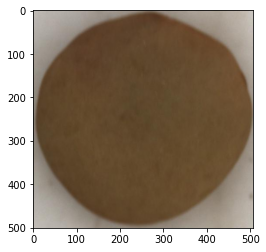

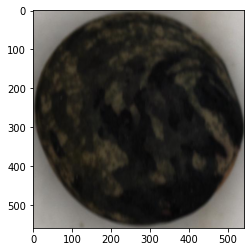

In [ ]:
# show original images
image_paths = ['real_regions/0003_16401081_12.png', 'real_regions/1003_16401081_41.png']

for path in image_paths:
    img = io.imread(path)
    plt.imshow(img)
    plt.show()

In [ ]:
#encode and decode the images

image_test_dataset = LentilDataset(image_paths, transform)


image_test_loader = DataLoader(
    image_test_dataset, 
    batch_size=2, 
    shuffle=False,
    num_workers=0
)

output_images = []
with torch.no_grad():
    for i, data in enumerate(image_test_loader):
        print(i)
        _, images = data
        images = images.to(device)
        output = model(images)
        output_images.extend(output.cpu().numpy())

0


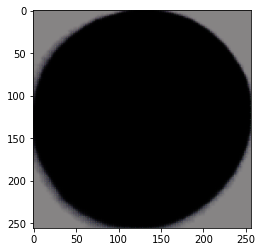

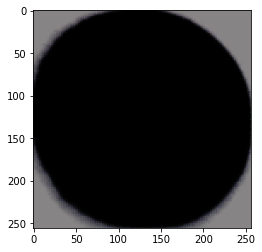

In [ ]:
# show decoded image
for img in output_images:
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    plt.imshow(img)
    plt.show()

**Encode the New Images (Images not in dataset used to train model)**

In [ ]:
# Load the best saved model. 
checkpoint = torch.load('CNNModel1/CNN1.pth', map_location=torch.device(str(device)))
# Define the base model.
model = CNN_Model()
# Load the weights. 
model.load_state_dict(checkpoint)
model = model.to(device)
model = model.eval()

In [ ]:
# Load the new dataset
df = pd.read_csv('metadata/new_lentil_paths.csv')
paths = df.Image.tolist()

image_dataset = LentilDataset(paths, transform)


image_loader = DataLoader(
    image_dataset, 
    batch_size=64, 
    shuffle=False,
    num_workers=0
)

output_images = []
output_items = []
with torch.no_grad():
    for i, data in enumerate(image_loader):
        print(i)
        items, images = data
        images = images.to(device)
        output = model.encoder(images)
        output_images.extend(output.cpu().numpy().tolist())
        output_items.extend(items.numpy().tolist())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [ ]:
# save the encoded features

output_paths = pd.DataFrame({"Image":[paths[i] for i in output_items]})
output_features = pd.DataFrame(output_images)

output_features = pd.concat([output_paths, output_features], axis=1)
output_features.head()

,Image,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,New_Lentils/brown-marbled-7059 (segmented)/164...,-50.450283,52.236862,0.633628,4.723947,33.048306,3.543474,4.561373,-36.000172,-23.961124,...,49.803268,47.657997,-37.987118,-13.245797,-37.147011,-29.830957,-22.331896,7.095768,-16.186466,-20.808908
1,New_Lentils/brown-marbled-7059 (segmented)/164...,-48.312485,62.156052,5.272187,-15.072780,18.748957,21.680712,22.211351,-39.481339,-9.529542,...,75.184654,44.500267,-35.753937,-2.275872,-38.642677,-14.952507,-30.110458,19.096302,1.749470,-20.440245
2,New_Lentils/brown-marbled-7059 (segmented)/164...,-44.977047,55.246964,2.174827,7.227791,35.441410,6.100941,1.521590,-42.522831,-24.255465,...,26.395638,38.903202,-35.802280,-10.539165,-35.634403,7.080564,-39.566311,8.433096,-19.139406,-12.709001
3,New_Lentils/brown-marbled-7059 (segmented)/164...,-43.257294,49.260265,3.264165,7.283667,36.659889,17.552383,22.371454,-33.606392,-28.563334,...,60.644123,38.959160,-38.668594,-21.103745,-33.084728,2.052317,-33.731533,24.735538,-17.802387,-12.816207
4,New_Lentils/brown-marbled-7059 (segmented)/164...,-41.884762,59.736393,5.756638,-14.397798,17.335243,22.010355,20.070347,-39.981277,-7.430474,...,59.058140,36.616913,-31.268185,1.117746,-35.339722,5.563846,-36.361195,18.578094,1.463712,-15.010604


In [ ]:
output_features.to_csv("metadata/new_images_cnn_encoded_features.csv", index=False)